In [1]:
!pip install accelerate -U
!pip install torch -U
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 5.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import random
import ast
import os
import keras
import accelerate
import re
import pickle

from keras import layers
from keras import models

from nltk.tokenize import RegexpTokenizer
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, AdamW
from datasets import Dataset
from tokenizers import ByteLevelBPETokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix

# **Creacion del Dataframe**

Funcion para lectura del archivo de texto

In [3]:
def leer_documento_txt(archivo, tamano_bloque=1024):
    documentos = []
    with open(archivo, 'r') as file:
        buffer = ""
        while True:
            chunk = file.read(tamano_bloque)
            if not chunk:
                break
            buffer += chunk
            # Dividimos el buffer por líneas
            lineas = buffer.splitlines(keepends=True)
            for i, linea in enumerate(lineas[:-1]):
                try:
                    # Intentamos evaluar la línea actual
                    documento = ast.literal_eval(linea.strip())
                    documentos.append(documento)
                except (SyntaxError, ValueError):
                    # Si ocurre un error, significa que la línea no está completa
                    # por lo tanto la combinamos con la siguiente
                    lineas[i + 1] = linea + lineas[i + 1]
            # Dejamos la última línea en el buffer por si está incompleta
            buffer = lineas[-1]
        # Procesamos cualquier línea restante en el buffer
        if buffer:
            try:
                documento = ast.literal_eval(buffer.strip())
                documentos.append(documento)
            except (SyntaxError, ValueError):
                print("Error al evaluar el contenido final del buffer")
    return documentos


Funcion para extraccion de oraciones de un documento del corpus

In [4]:
def extraer_oraciones(documentos):
    oraciones = []
    for documento in documentos:
        oraciones.extend(re.split(r'[.-]', documento['documento']))
    return [oracion.strip() for oracion in oraciones if oracion.strip()]

Funcion para desordenar las palabras de una oracion

In [5]:
def desordenar_palabras(oracion):
    palabras = oracion.split()
    random.shuffle(palabras)
    return ' '.join(palabras)

Funcion para modificar una proporcion de todas las oraciones del corpus y asignar labels correspondientes

In [6]:
def modificar_oraciones(oraciones, proporcion):
    total_oraciones = len(oraciones)
    num_modificaciones = int(total_oraciones * proporcion)
    indices_modificados = random.sample(range(total_oraciones), num_modificaciones)

    datos = []
    for i, oracion in enumerate(oraciones):
        if i in indices_modificados:
            oracion_modificada = desordenar_palabras(oracion)
            datos.append((oracion_modificada, 0))
        else:
            datos.append((oracion, 1))

    df = pd.DataFrame(datos, columns=['oracion', 'label'])
    return df

Creacion del dataframe

In [7]:
archivo = '/content/corpus (2).txt'
documentos = leer_documento_txt(archivo)
oraciones = extraer_oraciones(documentos)
proporcion = 0.4
df = modificar_oraciones(oraciones, proporcion)

Error al evaluar el contenido final del buffer


Visualización del Dataframe inicial

In [8]:
df

,oracion,label
0,"Chaska warmachas 5 watayuq kasqa, sapa punchaw...",1
1,"qipantas richkaspa, pillpintuta kallpakusqa wa...",0
2,"wikapakurqusqa, chayarqusqa rumi hawanman Chay...",0
3,"simihinaraqsi kichakurqusqa kirikurqusqas, Uya...",0
4,Llumpaytas Chaskaqa nanaywan waqasqa,1
...,...,...
2327,nisqataqmi Amarantu nisqataqmi Gutierrez Ñawpa...,0
2328,"20 thatkiykama, ch) kinrayninman: thatkiykama ...",1
2329,100 thatkikama kasqa Takirakunaqa mallkichakun...,1
2330,"Ayllunchikkunapiqa allpanmanhina, chirikayninm...",1


# **Entrenamiento con Metodos Clasicos**

## **Preprocesamiento**

Empezamos el preprocesamiento creando los conjunto de entrenamiento y test a partir del dataframe inicial.

In [ ]:
train_dataML, test_dataML = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
print(f'Tamaño Dataset Entrenamiento = {train_dataML.shape}')
print(f'Tamaño Dataset Test = {test_dataML.shape}')

Tamaño Dataset Entrenamiento = (2044, 2)
Tamaño Dataset Test = (512, 2)


A partir de esta informacion, se realizará un preprocesamiento del texto incluido en los datasets de entrenamiento y validación. El preprocesamiento incluirá pasar palabras a minusculas y eliminar signos ortográficos

In [ ]:
def preproceesing_ML(text):
    text = text.lower()
    tokenizer = RegexpTokenizer(r"\w+")
    text = tokenizer.tokenize(text)
    return ' '.join(text)

Se aplica la funcion de preprocesamiento a la data de entrenamiento y validación

In [ ]:
train_dataML['oracion'] = train_dataML['oracion'].apply(preproceesing_ML)
test_dataML['oracion'] = test_dataML['oracion'].apply(preproceesing_ML)

## **Construcción del Modelo**

Construimos un Pipeline que incluya un vectorizador Tfidf y un clasificador Multinomial de Bayes

In [ ]:
modelML = make_pipeline(TfidfVectorizer(min_df=5, max_df=0.25), MultinomialNB())

## **Entrenamiento**

In [ ]:
modelML.fit(train_dataML['oracion'], train_dataML['label'])

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_df=0.25, min_df=5)),
                ('multinomialnb', MultinomialNB())])

## **Resultados**

A partir del modelo entrenado, realizamos la predicción de resultados con el dataset de prueba

In [ ]:
predicted_categoriesML = modelML.predict(test_dataML['oracion'])

A partir de estos resultados, determinamos las metricas de exactitud y precisión

In [ ]:
accuracy_modelML = accuracy_score(predicted_categoriesML, test_dataML['label'])
precision_modelML = precision_score(predicted_categoriesML, test_dataML['label'], average="macro")
recall_modelML = recall_score(predicted_categoriesML, test_dataML['label'], average="macro")
print(f'Model ML - Accuracy {accuracy_modelML}')
print(f'Model ML - Precision {precision_modelML}')
print(f'Model ML - Recall {recall_modelML}')

Model ML - Accuracy 0.58984375
Model ML - Precision 0.4952088432435891
Model ML - Recall 0.47991415733351217


Asi mismo, graficamos la matriz de confusión

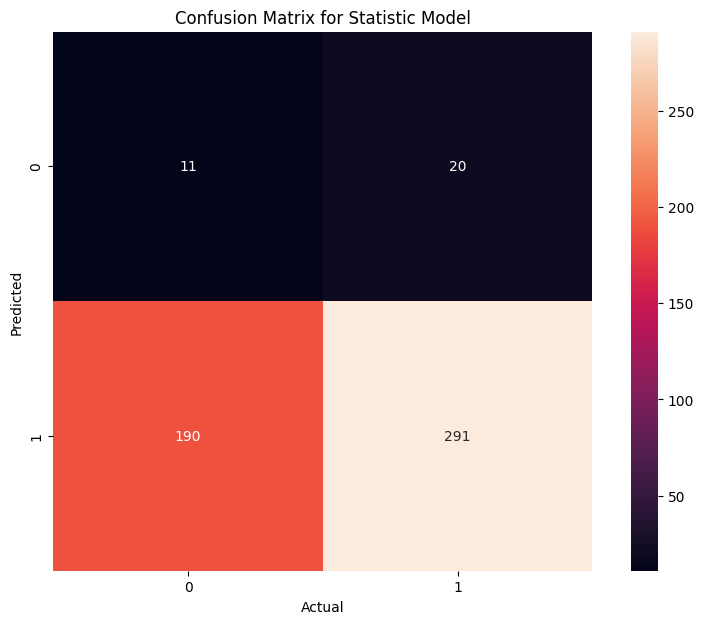

In [ ]:
confussinmatrixML = confusion_matrix(test_dataML['label'], predicted_categoriesML)
plt.figure(figsize=(10, 7))
ax = sns.heatmap(confussinmatrixML.T, square=True, annot=True, fmt="d")
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Confusion Matrix for Statistic Model')
plt.show()

# **Entrenamiento con Redes Neuronales**

## **Preprocesamiento**

Empezamos por crear los conjuntos de entrenamiento y validación a partir del dataframe inicial

In [9]:
sentences_NN = df['oracion'].values
y_NN = df['label'].values

In [10]:
sentences_trainNN, sentences_testNN, y_trainNN, y_testNN = train_test_split(sentences_NN, y_NN, stratify=y_NN, test_size=0.3, random_state=1000)

Revisamos las dimensiones de las variables generadas

In [11]:
print(f'Tamaño Conjunto Oraciones Entrenamiento = {sentences_trainNN.shape}')
print(f'Tamaño Conjunto Labels Entrenamiento = {y_trainNN.shape}')

Tamaño Conjunto Oraciones Entrenamiento = (1632,)
Tamaño Conjunto Labels Entrenamiento = (1632,)


In [12]:
print(f'Tamaño Conjunto Oraciones Test = {sentences_testNN.shape}')
print(f'Tamaño Conjunto Labels Test = {y_testNN.shape}')

Tamaño Conjunto Oraciones Test = (700,)
Tamaño Conjunto Labels Test = (700,)


Se entrena un tokenizer para tokenizar las palabras del dataset


In [13]:
tokenizerNN = Tokenizer(num_words=30000)
tokenizerNN.fit_on_texts(sentences_trainNN)

Se aplica el tokenizer  sobre los conjuntos de entrenamiento y test

In [14]:
X_train_NN = tokenizerNN.texts_to_sequences(sentences_trainNN)
X_test_NN = tokenizerNN.texts_to_sequences(sentences_testNN)
vocab_size = len(tokenizerNN.word_index) + 1
print(f'Tamaño de vocabulario: {vocab_size}')

Tamaño de vocabulario: 29016


Una vez tokenizados los conjuntos de entrenamiento, se procede a uniformizar los tamaños de las secuencias que ingresarán a la red neuronal a través de un pad

In [15]:
maxlen = 1000

In [16]:
X_train_NN = pad_sequences(X_train_NN, padding='post', maxlen=maxlen)
X_test_NN = pad_sequences(X_test_NN, padding='post', maxlen=maxlen)

## **Construcción del Modelo**

Se implementa una red neuronal con una capa de embedding de tamaño 250 y dos capas de LSTM bidireccional

In [17]:
embedding_dim = 300

modelNN = models.Sequential()
modelNN.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen))
modelNN.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
modelNN.add(layers.Bidirectional(layers.LSTM(64)))
modelNN.add(layers.Dense(1, activation='sigmoid'))

modelNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
modelNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         8704800   
                                                                 
 bidirectional (Bidirection  (None, 1000, 128)         186880    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 8990625 (34.30 MB)
Trainable params: 8990625 (34.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **Entrenamiento**

In [18]:
from keras.backend import clear_session
clear_session()
history = modelNN.fit(X_train_NN, y_trainNN,
                      epochs=15,
                      verbose=True,
                      validation_data=(X_test_NN, y_testNN),
                      batch_size=16)

Epoch 1/15
102/102 [==============================] - 54s 455ms/step - loss: 0.6779 - accuracy: 0.5999 - val_loss: 0.6880 - val_accuracy: 0.6000
Epoch 2/15
102/102 [==============================] - 27s 266ms/step - loss: 0.3289 - accuracy: 0.8578 - val_loss: 1.3944 - val_accuracy: 0.5600
Epoch 3/15
102/102 [==============================] - 25s 242ms/step - loss: 0.0443 - accuracy: 0.9841 - val_loss: 1.3411 - val_accuracy: 0.5671
Epoch 4/15
102/102 [==============================] - 21s 203ms/step - loss: 0.0200 - accuracy: 0.9939 - val_loss: 1.5335 - val_accuracy: 0.5743
Epoch 5/15
102/102 [==============================] - 21s 205ms/step - loss: 0.0062 - accuracy: 0.9975 - val_loss: 1.7701 - val_accuracy: 0.5586
Epoch 6/15
102/102 [==============================] - 20s 197ms/step - loss: 0.0031 - accuracy: 0.9982 - val_loss: 2.1328 - val_accuracy: 0.5686
Epoch 7/15
102/102 [==============================] - 19s 183ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 2.2256 - val_ac

## **Resultados**

En primer lugar, revisamos las curvas de entrenamiento para el loss y acurracy obtenidas al entrenar el modelo

In [19]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

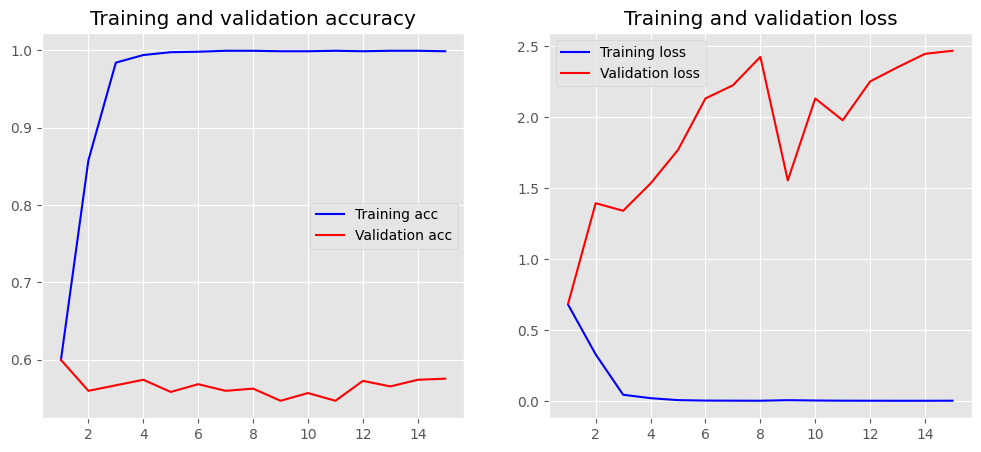

In [20]:
plot_history(history)

A partir de los resultados, realizamos la predicción de resultados con el dataset de prueba

In [21]:
predicted_categoriesNN = modelNN.predict(X_test_NN)

22/22 [==============================] - 3s 49ms/step


In [22]:
for i in range(len(predicted_categoriesNN)):
  predicted_categoriesNN[i] = round(predicted_categoriesNN[i].item())

Ahora, determinamos las metricas de exactitud y precisión

In [23]:
accuracy_modelNN  = accuracy_score(predicted_categoriesNN, y_testNN)
precision_modelNN = precision_score(predicted_categoriesNN, y_testNN, average="macro")
recall_modelNN = recall_score(predicted_categoriesNN, y_testNN, average="macro")
print(f'Model NN - Accuracy {accuracy_modelNN}')
print(f'Model NN - Precision {precision_modelNN}')
print(f'Model NN - Recall {recall_modelNN}')

Model NN - Accuracy 0.5757142857142857
Model NN - Precision 0.543452380952381
Model NN - Recall 0.5471667635846741


Finalmente, graficamos la matriz de confusion

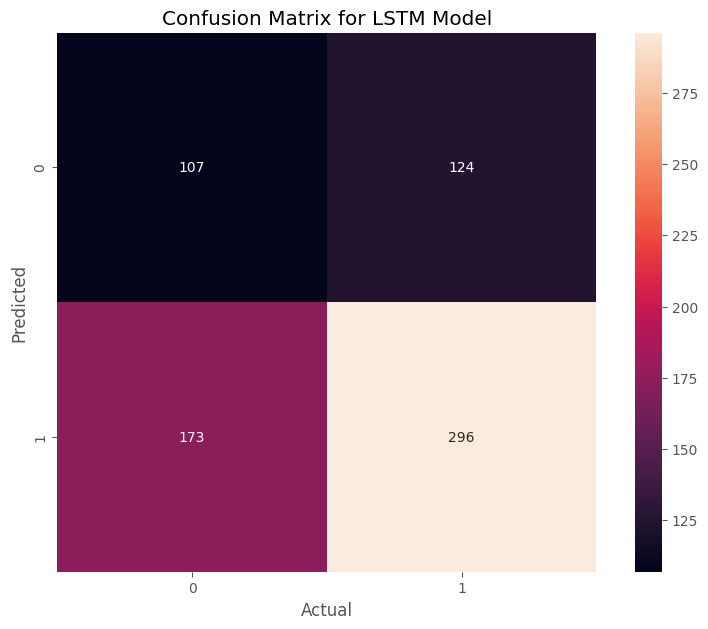

In [24]:
confussinmatrixNN = confusion_matrix(y_testNN, predicted_categoriesNN)
plt.figure(figsize=(10, 7))
ax = sns.heatmap(confussinmatrixNN.T, square=True, annot=True, fmt="d")
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Confusion Matrix for LSTM Model')
plt.show()

# **Entrenamiento con Transformers**

## **Preprocesamiento**

### **Tokenizer**

Empezamos entrenando un tokenizer que permita realizar la tokenizacion del texto en quechua

In [ ]:
tokenizerQuechua = ByteLevelBPETokenizer()

In [ ]:
tokenizerQuechua.train(files=archivo, vocab_size=50000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

Se guarda el tokenizer en un directorio

In [ ]:
directory = "/content/quechua_tokenizer"
os.makedirs(directory, exist_ok=True)

In [ ]:
tokenizerQuechua.save_model(directory)

['/content/quechua_tokenizer/vocab.json',
 '/content/quechua_tokenizer/merges.txt']

### **Dataset**

En primer lugar, se crea un DataFrame a partir de los datos que se tienen

In [ ]:
oracionesTF = []
labelsTF = []
for i in range(len(df)):
  oracionesTF.append(df['oracion'][i])
  labelsTF.append(df['label'][i])

In [ ]:
dataTF = {'text': oracionesTF, 'label': labelsTF}  # Sustituye con tus datos reales
dataset_df = pd.DataFrame(dataTF)

Posteriormente, se divide el dataset en un conjunto de entrenamiento y otro de test

In [ ]:
train_df, test_df = train_test_split(dataset_df, test_size=0.2)

## **Modelo**

### **RoBERTa**

Se empieza creando un objeto RobertaTokenizerFast que este preentrenado con el tokenizer anterior

In [ ]:
hf_tokenizer = RobertaTokenizerFast.from_pretrained("./quechua_tokenizer")

Ademas, se usa el modelo de RobertaForSequenceClassification que esta preentrenado con su modelo base

In [ ]:
model =  RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **QuechuaDataset**

Se crea la clase QuechuaDataset a traves de la cual se almacenará la información

In [ ]:
class QuechuaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if isinstance(idx, int):  # Handle single index
            text = self.texts[idx]
            label = self.labels[idx]
        else:  # Handle batch of indices
            text = [self.texts[i] for i in idx]
            label = [self.labels[i] for i in idx]

        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')

        # Convert label to tensor if it's not already
        if not isinstance(label, torch.Tensor):
            label = torch.tensor(label)

        return {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'labels': label
        }


Se crean los objetos de QuechuaDataset para el entrenamiento y evaluacion; incluyendo el tokenizer de RoBERTa

In [ ]:
train_dataset = QuechuaDataset(train_df['text'].tolist(), train_df['label'].tolist(), hf_tokenizer, max_length=250)
test_dataset = QuechuaDataset(test_df['text'].tolist(), test_df['label'].tolist(), hf_tokenizer, max_length=250)

Se crean DataLoaders con los Datasets para realizar el entrenamiento posterior del modelo

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8)

Por ultimo, se define el optimizer y la funcion de perdida para el modelo

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## **Entrenamiento**

Se verifica si cuda esta disponible para el entrenamiento

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Se realiza el entrenamiento

In [ ]:
for epoch in range(1):  # Número de épocas
    model.train()
    total_loss = 0
    for batch in train_loader:
        # Adjust unpacking based on what is printed above
        # For example, if batch is a dictionary:
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device) # Move labels to the GPU

        optimizer.zero_grad()

        # Check for NaN or Inf in inputs
        for key, val in inputs.items():
            if torch.isnan(val).any() or torch.isinf(val).any():
                print(f"Found NaN or Inf in input tensor: {key}")

        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss}")


KeyboardInterrupt: 

## **Resultado**

Realizamos las pruebas del modelo con el DataLoader creado para los datos de evaluacion

In [ ]:
model.eval()
predictions, true_labels = [], []

In [ ]:
with torch.no_grad():
    for batch in test_loader:
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device) # Move labels to the GPU

        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

A partir de los resultados, obtenemos las metricas de evaluacion

In [ ]:
accuracy_modelTF  = accuracy_score(true_labels, predictions)
precision_modelTF = precision_score(true_labels, predictions, average="macro")
recall_modelTF = recall_score(true_labels, predictions, average="macro")
print(f'Model TF - Accuracy {accuracy_modelTF}')
print(f'Model TF - Precision {precision_modelTF}')
print(f'Model TF - Recall {recall_modelTF}')

Model TF - Accuracy 0.55859375
Model TF - Precision 0.279296875
Model TF - Recall 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tambien graficamos la matriz de confusion

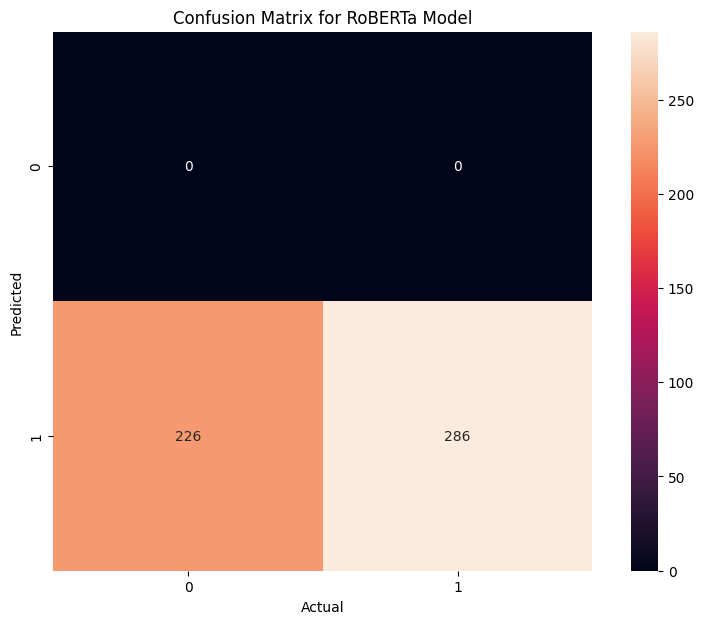

In [ ]:
confussinmatrixTF = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
ax = sns.heatmap(confussinmatrixTF.T, square=True, annot=True, fmt="d")
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Confusion Matrix for RoBERTa Model')
plt.show()

# **Seleccion de modelo**

Basado en los valores de accuracy obtenidos con los tres modelos, se concluye que el mejor modelo fue el que empleaba LSTM. Por tal motivo, se procebe a guardarlo.

In [25]:
# Guardar el modelo
modelNN.save("modelNN.h5")
# Guardar el tokenizador
with open("tokenizerNN.pkl", "wb") as handle:
    pickle.dump(tokenizerNN, handle, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
modelNN_app = keras.models.load_model("modelNN.h5")
with open("tokenizerNN.pkl", "rb") as handle:
    tokenizerNN_app = pickle.load(handle)

In [ ]:
maxlen = 1000
text = ["runakunas karqan. pisi hark’aq chay mana mikhunaqa Imaraykuchus llakikuypi imaymana unquywan unqupuchkanku. rikhuripun, unquykunas tiyaq ruru llapan chakra pisimanta tarikapusqaku; mikhunanku allinchu pisitas imaymana uripun, hatun kapun, rurasqankupas Tukukuypitaqsi, unquykunamantas llapan pampapi imaymana runas allp’a"]
sequences = tokenizerNN_app.texts_to_sequences(text)
padded_sequences = pad_sequences(sequences, padding='post', maxlen=maxlen)
prediction = modelNN_app.predict(padded_sequences)
predicted_label = prediction[0][0]
response = {"prediction": predicted_label}
response